In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os

In [2]:
DS='ran_synth_08_bw'
ID=0

code_dir = os.getcwd()
ac_relative_path = f"../../data/{DS}/{DS}/point_based_ac_{ID:02}.npy"
ac=np.load(os.path.join(code_dir, ac_relative_path))

mask_relative_path = f"../../data/{DS}/msk/msk_{ID:02}.npy"
mask=np.load(os.path.join(code_dir, mask_relative_path))

#ac=np.load('/DATA/vito/data/'+DS+'/'+DS+f'/point_based_ac_{ID:02}.npy')
#mask=np.load('/DATA/vito/data/'+DS+f'/msk/msk_{ID:02}.npy')


In [3]:
mask_ids, counts=np.unique(mask, return_counts=True)
mask_ids, counts = mask_ids[1:], counts[1:]
area = counts * (0.2 * 0.2)
mask_ids = mask_ids[np.argsort(area)]
area = np.sort(area)

In [4]:
mapping = np.zeros(mask_ids.max() + 1, dtype=ac[1].dtype) 
mapping[mask_ids] = ac[1]
iou_mask = mapping[mask]

In [38]:
#not using
iou_mask = mask.copy().astype(ac[1].dtype)
for original, new in zip(mask_ids, ac[1]):
    iou_mask[mask == original] = new

mapping = dict(zip(mask_ids, ac[1]))

# Vectorized replacement using a dictionary
iou_mask2 = np.vectorize(lambda x: mapping.get(x, x))(mask)

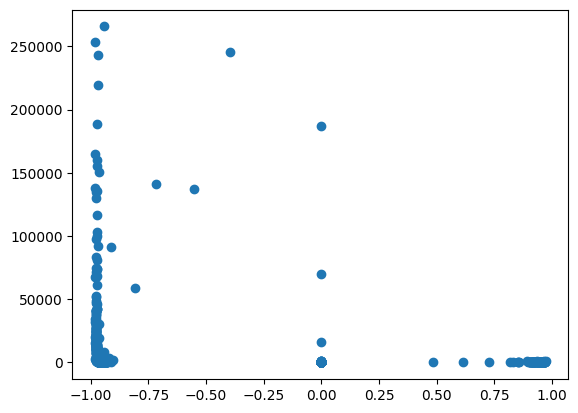

In [16]:
plt.scatter(ac[1],ac[2])

In [5]:
from scipy.ndimage import binary_dilation

edges = np.zeros_like(iou_mask, dtype=bool)
mask = mask>0
edges |= binary_dilation(mask) & ~mask

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(iou_mask))  
plt.colorbar()
plt.contour(edges, colors='red') 
plt.title("Edges of Labels")
plt.show()

In [6]:
iou_mask_temp=iou_mask.copy()
iou_mask_temp[mask==0]=np.nan

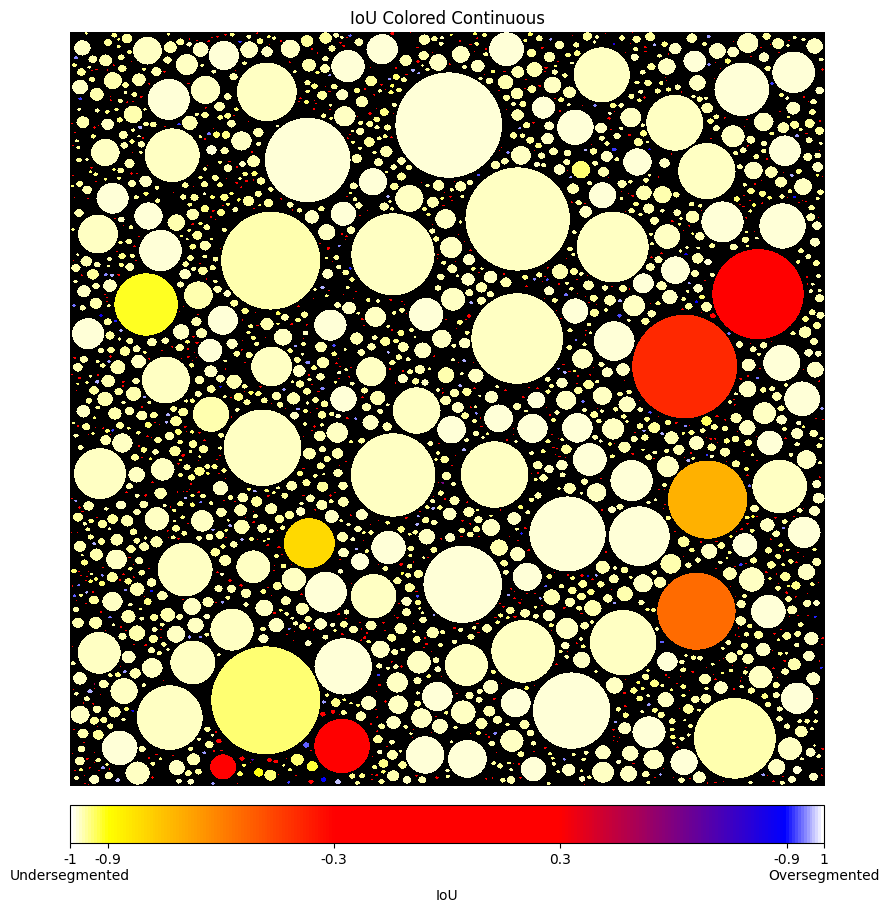

In [14]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    (0.0, 'white'),   # Extreme low (-1 normalized to 0)
    (0.05, 'yellow'), # -0.9 normalized to 0.05
    (0.35, 'red'),    # -0.3 normalized to 0.35
    (0.65, 'red'),    # 0.3 normalized to 0.65
    (0.95, 'blue'),   # 0.9 normalized to 0.95
    (1.0, 'white')    # Extreme high (1 normalized to 1)
]

def create_gradient_cmap(colors):
    positions, color_vals = zip(*colors)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, color_vals)))
    return cmap

cmap = create_gradient_cmap(colors)
cmap.set_bad(color='black')

iou_mask_temp=iou_mask.copy()
iou_mask_temp[mask==0]=np.nan

fig, ax = plt.subplots(figsize=(9,10))
cax = ax.imshow(iou_mask_temp, cmap=cmap, vmin=-1, vmax=1)  
cbar = fig.colorbar(cax, ticks=[-1, -0.9, -0.3, 0.3, 0.9, 1],label='IoU', pad=0.02, orientation='horizontal')
cbar.ax.set_xticklabels(['-1\nUndersegmented','-0.9', '-0.3','0.3','-0.9', '1\nOversegmented']) 

plt.axis('off')
plt.title('IoU Colored Continuous')
plt.tight_layout()
plt.show()

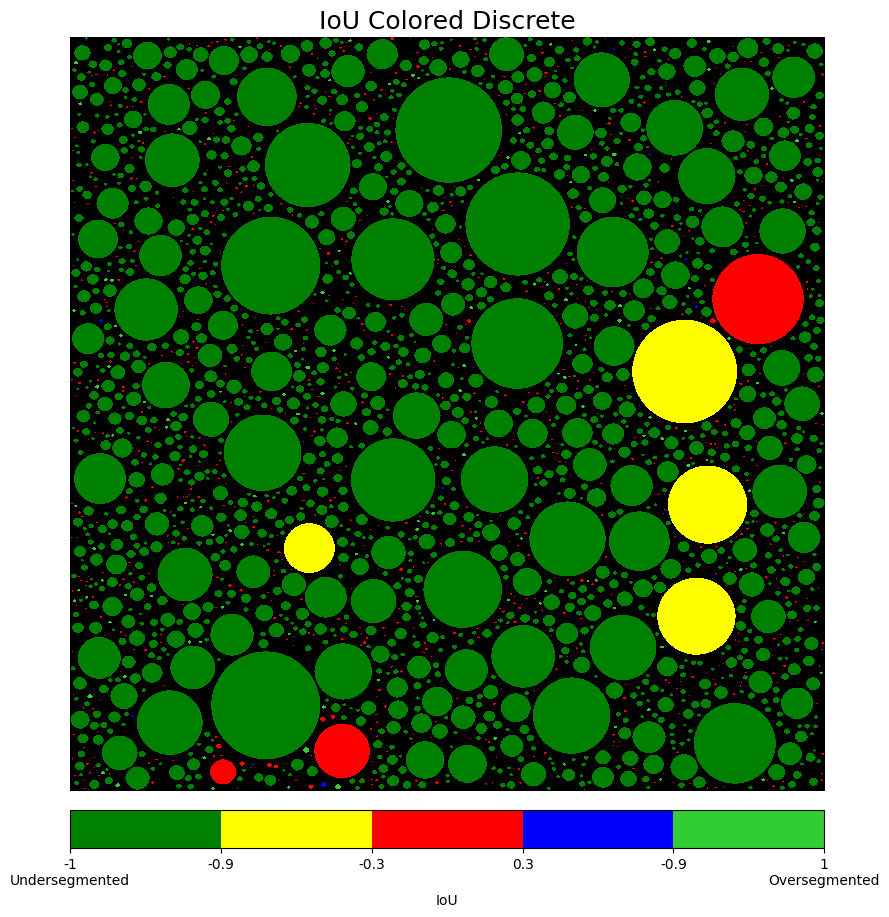

In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['green','yellow', 'red', 'blue', 'limegreen'] 
boundaries = [-1, -0.9, -0.3, 0.3, 0.9, 1] 
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N)

cmap.set_bad(color='black')

iou_mask_temp=iou_mask.copy()
iou_mask_temp[mask==0]=np.nan

fig, ax = plt.subplots(figsize=(9,10))

cax = ax.imshow(iou_mask_temp, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-1, -0.9, -0.3, 0.3, 0.9, 1],label='IoU', pad=0.02, orientation='horizontal')
cbar.ax.set_xticklabels(['-1\nUndersegmented','-0.9', '-0.3','0.3','-0.9', '1\nOversegmented']) 

plt.axis('off')
plt.title('IoU Colored Discrete', fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
labels=['Modified SAM','Direct SAM (300 spg, 0 crop)']

c=0
fig,ax=plt.subplots(2,2,figsize=(15,15))
ax=ax.flatten()
lw=2

for list_of_mask in [modified_masks,ar_mask300_nms]:

    

    ax[c].imshow(np.zeros((3000,3000)), cmap='binary')
    ax[c+2].imshow(np.zeros((3000,3000)), cmap='binary')

    for i in range(len(list_of_label)):
        contours = plt.contour(list_of_label[i], levels=[0.5], colors='none')

        for contour_path in contours.collections[0].get_paths():
            # hatch option 	{'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
            msk_iou=kdc_iou[i]
            if abs(msk_iou)<0.5:#missed
                patch1 = patches.PathPatch(contour_path, fill=True, facecolor='red', edgecolor='k',alpha=0.4)
                patch2 = patches.PathPatch(contour_path, fill=False, edgecolor='k',linewidth=lw)
                ax[c].add_patch(patch1)
                ax[c].add_patch(patch2)
                #ax[c+2].add_patch(patch2)
            elif (abs(msk_iou)>=0.5 and abs(msk_iou)<0.9):#hit but not perfect
                if msk_iou>0:#overseg
                    patch1 = patches.PathPatch(contour_path, fill=True, facecolor='blue', edgecolor='k',alpha=0.4)
                    patch2 = patches.PathPatch(contour_path, fill=False, edgecolor='k',linewidth=lw)
                elif msk_iou<0:#underseg
                    patch1 = patches.PathPatch(contour_path, fill=True, facecolor='yellow', edgecolor='k',alpha=0.4)
                    patch2 = patches.PathPatch(contour_path, fill=False, edgecolor='k',linewidth=lw)
                #ax[c].add_patch(patch2)
                ax[c+2].add_patch(patch1)
                ax[c+2].add_patch(patch2)
            else:
                patch1 = patches.PathPatch(contour_path, fill=False, edgecolor='k',linewidth=lw)
                patch2 = patches.PathPatch(contour_path, fill=False, edgecolor='k',linewidth=lw)
                ax[c].add_patch(patch1)
                #ax[c].add_patch(patch2)
                #ax[c+2].add_patch(patch1)
                ax[c+2].add_patch(patch2)

    legend_patches = [
        patches.Patch(facecolor='red', edgecolor='k',linewidth=4, label='Missed (|iou|: <0.5)'),
        #patches.Patch(facecolor='blue', edgecolor='k', label='Overseg (|iou|: 0.5-0.9)'),
        #patches.Patch(facecolor='yellow', edgecolor='k', label='Underseg (|iou|: 0.5-0.9)'),
        patches.Patch(facecolor='none', edgecolor='k',linewidth=4, label='Perfect Hit (|iou|: >=0.9)')
    ]
    ax[c].legend(handles=legend_patches, loc='upper right')
    ax[c].set_title(labels[c]+' Missed pebbles', fontsize=18)
    ax[c].axis('off')
    legend_patches = [
        #patches.Patch(facecolor='red', edgecolor='k', label='Missed (|iou|: <0.5)'),
        patches.Patch(facecolor='blue', edgecolor='k',linewidth=4, label='Overseg (|iou|: 0.5-0.9)'),
        patches.Patch(facecolor='yellow', edgecolor='k',linewidth=4, label='Underseg (|iou|: 0.5-0.9)'),
        patches.Patch(facecolor='none', edgecolor='k',linewidth=4, label='Perfect Hit (|iou|: >=0.9)')
    ]
    ax[c+2].legend(handles=legend_patches, loc='upper right')
    ax[c+2].set_title(labels[c]+' Under-/Over-segmented pebbles', fontsize=18)
    ax[c+2].axis('off')
    c+=1
plt.tight_layout()
plt.show()